# Project Background

## Business Problem
The business refers to the collective facilities and terminals that conduct maritime trade, and which handle country's harbours and shipping.

As a result of country being predominantly a transhipment port, it is highly sensitive to seasonal product trends in different countries as well as frequent unplanned changes to arrival times for incoming and outgoing ships. 
The company is looking for a solution that can analyze containers transhipment information, port congestion and identify patterns that can be used to improve planning around: \
I. Potential delays in berthing  \
II. Duration of vessel stay \
III. Number of incoming container


## Business Objective
- Identify the trends and predict the changes of vessel arrival and departure to optimize ground processes during congestion and seasonal spikes.

- Identify the features that contribute to better visibility of incoming vessel and container in time series.

- Identify seasonal trends by region / country and forecast surges in port call, berth and unberth request, container movement based on time series to aid in the agile deployment of resources

- Identify features that contribute to berth time, vessel dwell and container dwell.


## Analytics Objective

- Identify the trends and predict the changes of vessel berth and unberth.

- Analyse the features in time series and it's correlation with target label.

- Identify and prioritize the features in particular.

- Identify seasonal trends by region / country and forecast on demand surge.

- Identify and analyze the features that contribute to berth time, vessel dwell and container dwell.

## Table of contents

* [0. Initial Setup](#0.InitialSetup)

* [1. Reading Data](#1.ReadingData)

* [2. Features Engineering](#2.FeaturesEngineering)

* [3. Data Cleaning and Initial Processing](#3.DataCleaningandInitialProcessing)

* [4. EDA](#4.EDA)

* [5. Machine Learning Model](#5.MachineLearningModel)  

## 0. Initial Setup <a class="anchor" id="0.InitialSetup"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt


#Machine learning packages
import statistics
import sklearn.metrics as metrics
import math
import sklearn.metrics as metrics
import sklearn.metrics as sklm

import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

from scipy.stats import uniform, truncnorm, randint
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import RandomizedSearchCV

from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import auc
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest

from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
%matplotlib inline

from itertools import product

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

sns.set(rc={'figure.figsize':(11,4)})

## 1. Reading Data <a class="anchor" id="1.ReadingData"></a>

In [3]:
df = pd.read_csv("sample_30000.csv") 
ports = pd.read_csv('country_codes.csv')

In [4]:
df

,EVENT_C,CNTR_STATUS_C,DISC_PORT1_C,LOAD_PORT_C,ABBR_VESSEL_M1,BTR1,ATD1,ATU1,LINE_C1_GROUP,SERVICE_C1,SERVICE_TYPE_DESC_X1,DIRECTION_C1,CONSORTIUM_C1,CAPACITY1,ABBR_VESSEL_M2,BTR2,ATD2,ATU2,LINE_C2_GROUP,SERVICE_C2,SERVICE_TYPE_DESC_X2,DIRECTION_C2,CONSORTIUM_C2,CAPACITY2,DERIVED_CNTR_PURP_C,OPR_GROUP_C,SUMOFBOX_Q,SUMOFTEU_Q
0,DISC,F,GBSOU,TWKHH,V12780,2019/07/12 23:24:00,2019/07/12 23:39:00,2019/07/13 11:16:00,L349,S7530,INTRA-ASIA,W,NaN,3000.0,V10848,2019/07/13 16:56:00,2019/07/13 17:46:00,2019/07/14 11:53:00,L344,S7517,EUROPE FAR EAST,W,C5113,15000.0,TSHIP,O536,2,4.0
1,DISC,F,BDCGP,NLRTM,V11955,2017/04/12 9:24:00,2017/04/12 9:59:00,2017/04/13 6:36:00,L391,S7434,NaN,E,C5100,10000.0,V10147,2017/04/19 1:38:00,2017/04/19 14:28:00,2017/04/20 19:20:00,L381,S7681,COMMON FEEDER,W,NaN,2000.0,TSHIP,O372,5,10.0
2,DISC,F,NGTIN,AUSYD,V12673,2018/08/28 20:56:00,2018/08/29 1:48:00,2018/08/30 4:40:00,L344,S7503,"NORTH-SOUTH (TO REG 50,70,82)",W,C5049,7000.0,V13020,2018/09/03 21:06:00,2018/09/03 23:06:00,2018/09/04 7:58:00,L390,S7496,AFRICA,W,C5160,4000.0,TSHIP,O388,1,2.0
3,LOAD,F,TWKHH,DEBRV,V10542,2017/07/27 17:54:00,2017/07/28 8:36:00,2017/07/29 4:33:00,L390,S7516,NaN,E,NaN,2000.0,V11194,2017/07/23 7:46:00,2017/07/23 9:31:00,2017/07/23 17:01:00,L348,S7574,EUROPE FAR EAST,E,C5109,19000.0,TSHIP,O390,7,14.0
4,DISC,F,SAJED,TWKHH,V12539,2019/10/22 2:44:00,2019/10/22 3:39:00,2019/10/23 10:01:00,L346,S7615,TRANS-PACIFIC VIA SUEZ,E,C5059,10000.0,V10329,2019/10/31 9:32:00,2019/11/01 8:12:00,2019/11/02 11:04:00,L367,S7697,EFE/MEDITTERANEAN,W,C5059,13000.0,TSHIP,O372,11,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,LOAD,F,AUMEL,PHMNL,V11567,2019/12/16 18:28:00,2019/12/16 18:03:00,2019/12/18 4:49:00,L390,S7511,AUSTRALASIA,S,C5164,6000.0,V10647,2019/12/13 8:34:00,2019/12/13 15:04:00,2019/12/14 13:07:00,L347,S7494,COMMON FEEDER,E,C5099,2000.0,TSHIP,O390,6,9.0
29996,LOAD,F,USTW1,MYPGU,V12249,2018/07/10 5:50:00,2018/07/10 7:45:00,2018/07/11 6:12:00,L367,S7462,TRANS-PACIFIC,E,C5059,9000.0,V10747,2018/07/07 18:14:00,2018/07/07 15:54:00,2018/07/08 5:46:00,L402,S7539,NaN,E,NaN,300.0,TSHIP,O372,4,8.0
29997,LOAD,F,PHMNL,MYPGU,V13129,2019/04/09 5:18:00,2019/04/09 4:48:00,2019/04/10 18:20:00,L391,S7397,DEDICATED FEEDER,E,C5020,3000.0,V12165,2019/03/19 23:38:00,2019/03/20 0:03:00,2019/03/20 14:10:00,L380,S7539,COMMON FEEDER,E,NaN,300.0,TSHIP,O372,5,10.0
29998,LOAD,E,CNNGB,QAHMD,V11045,2018/02/04 7:08:00,2018/02/04 9:43:00,2018/02/04 20:38:00,L352,S7639,INTRA-ASIA EXTENDED,E,C5113,10000.0,V10503,2018/01/29 12:58:00,2018/01/29 20:08:00,2018/01/30 12:30:00,L344,S7359,INTRA-ASIA EXTENDED,E,C5113,9000.0,TSHIP,O536,26,26.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   EVENT_C               30000 non-null  object 
 1   CNTR_STATUS_C         30000 non-null  object 
 2   DISC_PORT1_C          30000 non-null  object 
 3   LOAD_PORT_C           30000 non-null  object 
 4   ABBR_VESSEL_M1        30000 non-null  object 
 5   BTR1                  30000 non-null  object 
 6   ATD1                  30000 non-null  object 
 7   ATU1                  30000 non-null  object 
 8   LINE_C1_GROUP         30000 non-null  object 
 9   SERVICE_C1            30000 non-null  object 
 10  SERVICE_TYPE_DESC_X1  26453 non-null  object 
 11  DIRECTION_C1          30000 non-null  object 
 12  CONSORTIUM_C1         22279 non-null  object 
 13  CAPACITY1             30000 non-null  float64
 14  ABBR_VESSEL_M2        30000 non-null  object 
 15  BTR2               

## 2. Features Engineering <a class="anchor" id="2.FeaturesEngineering"></a>

In [6]:
config={       
   
    "TIDY_DATES": ['BTR1','ATD1','ATU1','BTR2','ATD2','ATU2'],  #list of columns to be formatted into datetime data types
    "LAG_COLS": ['SUMOFTEU_Q','SUMOFBOX_Q'], #columns names for which moving average/trend variable has to be created
    "LAG": [2,3,5,7], #size for moving average window
}

In [7]:
def get_tidy_dates(df, config):    
    
    df[config['TIDY_DATES']]=df[config['TIDY_DATES']].apply(pd.to_datetime,format='%Y-%m-%d')
        
    return df  

In [8]:
def get_time_related_features(df):  
    
    """
    Get a dataframe creating all time/seasonality related features on a given date column
    Inputs      : df      = psa dataframe with delay metrics calculated as a column
    outputs     : Updated data frame with all new time/seasonality features created
    """
    
    #time seasionality   
    df['ARRIVAL_DATE'] =df['ATD1'].dt.strftime('%Y-%m-%d')
    df['ARRIVAL_WEEK']=df['ATD1'].dt.strftime('%Y-%U')
    df['ARRIVAL_MONTH']=df['ATD1'].dt.strftime('%Y-%m')
    df['DAY_OF_MONTH']=df['ATD1'].dt.day
    df['WEEK_OF_YEAR']=df['ATD1'].dt.isocalendar().week
    df['MONTH_OF_YEAR']=df['ATD1'].dt.month
    df['QUARTER_OF_YEAR']=df['ATD1'].dt.quarter
    df['YEAR']=df['ATD1'].dt.year
    
    return df

In [9]:
def get_ports_country(df,ports):
    
    """
    Get country of the ports merged with PSA data frame
    Inputs      : df      = psa dataframe
                : ports   = ports dataframe
    outputs     : updated data frame with ports country mapped to psa data frame
    """
    
    df['DISC_PORT1_C_ID'] = df.DISC_PORT1_C.astype(str).str[:2]
    df['LOAD_PORT_ID'] = df.LOAD_PORT_C.astype(str).str[:2]
    
    df=pd.merge(df, ports,left_on='DISC_PORT1_C_ID',right_on='ISO 3166-1',how='left')
    df=pd.merge(df, ports,left_on='LOAD_PORT_ID',right_on='ISO 3166-1',how='left')

    df.rename(columns={'Country Name_x':'DISC_COUNTRY','Country Name_y':'LOAD_COUNTRY'}, inplace=True)
    df=df.drop(['ISO 3166-1_x','ISO 3166-1_y','DISC_PORT1_C_ID','LOAD_PORT_ID'],axis=1)
    
    return df

In [10]:
def get_vessel_type(df):
    
    """
    Get a vessel category type based n capacity i.e. feeder, panamax, etc.
    Inputs      : df      = psa dataframe
    outputs     : updated data frame with vessel type crated
    """
    
    df['VESSEL_TYPE_M1']=np.where((df.CAPACITY1<=3000),"Feeder",np.where(((df.CAPACITY1>3000)&(df.CAPACITY1<=8000)),"Intermediate",np.where(((df.CAPACITY1>8000)&(df.CAPACITY1<=15000)),"Neo-Panamax","Post-Panamax")))
    df['VESSEL_TYPE_M2']=np.where((df.CAPACITY2<=3000),"Feeder",np.where(((df.CAPACITY2>3000)&(df.CAPACITY2<=8000)),"Intermediate",np.where(((df.CAPACITY2>8000)&(df.CAPACITY2<=15000)),"Neo-Panamax","Post-Panamax")))
    
    df['CONTAINER_LOAD_VESSEL_TYPE']=np.where(df.EVENT_C=="LOAD",df.VESSEL_TYPE_M1,df.VESSEL_TYPE_M2)
    
    return df

In [11]:
def get_lag_variables(df, config):
    
    """
    Get a dataframe summarizing container delays
    Inputs      : df                 = psa dataframe
                : config['LAG_COLS'] = list of columns specified in config for which lag and trend(moving average) variables has to be created
                : config['LAG'] = window of moving average i.e., 3 days/7 days moving average to be specified in config
    outputs     : updated data frame summarizing container delays
    """
    for col,lag  in product(config['LAG_COLS'],config['LAG']):
        df[col+'_'+str(lag)] = df[col].rolling(lag,1).mean()    

    return df

In [12]:
def get_duration_metrics(df):
    
    """
    Get delay metrics such as berthing delay, unberthing delay and container delayds
    Inputs      : df      = psa dataframe
    outputs     : updated data frame with all the delay metrics
    """
    
    df['BERTHING_TIME']=(df.ATD1-df.BTR1)/np.timedelta64(1,'h') # Berth time required for each vessel starts to dock
    df['VESSEL_DWELL']=(df.ATU1-df.ATD1)/np.timedelta64(1,'h')  # Duration vessel stays at the port
    df['CONTAINER_DWELL']=np.where((df.EVENT_C=='DISC'),(df.ATU2-df.ATD1)/np.timedelta64(1,'h'),
                                   (df.ATU1-df.ATD2)/np.timedelta64(1,'h')) # Duration container stays at the port
    
    return df

In [13]:
df2 = get_tidy_dates(df,config)
df2 = get_time_related_features(df2)
df2 = get_ports_country(df2, ports)
df2 = get_vessel_type(df2)
df2 = get_lag_variables(df2,config)
df2 = get_duration_metrics(df2)

In [14]:
df2['ARRIVAL_DATE'] = df2.ARRIVAL_DATE.astype('datetime64[ns]')
df2['WEEK_OF_YEAR'] = df2.WEEK_OF_YEAR.astype('int64')
df2 = df2.sort_values('ARRIVAL_DATE')
df2 = df2.set_index('ARRIVAL_DATE')

In [15]:
df2

,EVENT_C,CNTR_STATUS_C,DISC_PORT1_C,LOAD_PORT_C,ABBR_VESSEL_M1,BTR1,ATD1,ATU1,LINE_C1_GROUP,SERVICE_C1,SERVICE_TYPE_DESC_X1,DIRECTION_C1,CONSORTIUM_C1,CAPACITY1,ABBR_VESSEL_M2,BTR2,ATD2,ATU2,LINE_C2_GROUP,SERVICE_C2,SERVICE_TYPE_DESC_X2,DIRECTION_C2,CONSORTIUM_C2,CAPACITY2,DERIVED_CNTR_PURP_C,OPR_GROUP_C,SUMOFBOX_Q,SUMOFTEU_Q,ARRIVAL_WEEK,ARRIVAL_MONTH,DAY_OF_MONTH,WEEK_OF_YEAR,MONTH_OF_YEAR,QUARTER_OF_YEAR,YEAR,DISC_COUNTRY,LOAD_COUNTRY,VESSEL_TYPE_M1,VESSEL_TYPE_M2,CONTAINER_LOAD_VESSEL_TYPE,SUMOFTEU_Q_2,SUMOFTEU_Q_3,SUMOFTEU_Q_5,SUMOFTEU_Q_7,SUMOFBOX_Q_2,SUMOFBOX_Q_3,SUMOFBOX_Q_5,SUMOFBOX_Q_7,BERTHING_TIME,VESSEL_DWELL,CONTAINER_DWELL
ARRIVAL_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01,LOAD,F,IDSRG,USNYC,V10082,2016-12-31 21:58:00,2017-01-01 20:57:00,2017-01-02 05:39:00,L376,S7429,COMMON FEEDER,S,NaN,1000.0,V11511,2016-12-30 10:50:00,2016-12-30 12:45:00,2016-12-31 12:48:00,L367,S7463,TRANS-PACIFIC VIA SUEZ,E,C5100,8000.0,TSHIP,O372,15,15.0,2017-01,2017-01,1,52,1,1,2017,Indonesia,United States,Feeder,Intermediate,Feeder,10.5,11.666667,11.00,10.142857,9.0,10.666667,9.4,8.857143,22.983333,8.700000,64.900000
2017-01-01,LOAD,F,ITGOA,BDCGP,V11630,2017-01-01 12:02:00,2017-01-01 13:32:00,2017-01-02 04:34:00,L391,S7454,NaN,W,C5133,9000.0,V11766,2016-12-30 19:00:00,2016-12-30 19:25:00,2016-12-31 20:03:00,L373,S7535,COMMON FEEDER,W,C5117,2000.0,TSHIP,O489,4,7.0,2017-01,2017-01,1,52,1,1,2017,Italy,Bangladesh,Neo-Panamax,Feeder,Neo-Panamax,5.0,4.333333,5.60,19.571429,3.0,2.666667,3.2,13.428571,1.500000,15.033333,57.150000
2017-01-01,LOAD,F,FRLEH,JPTYO,V12345,2017-01-01 07:47:00,2017-01-01 09:37:00,2017-01-02 10:04:00,L367,S7447,EUROPE FAR EAST,W,C5100,13000.0,V11248,2016-12-28 13:04:00,2016-12-28 13:29:00,2016-12-29 09:17:00,L391,S7584,INTRA-ASIA,S,C5168,5000.0,TSHIP,O489,4,6.0,2017-01,2017-01,1,52,1,1,2017,France,Japan,Neo-Panamax,Intermediate,Neo-Panamax,8.0,7.000000,7.20,5.571429,4.5,4.666667,5.8,4.428571,1.833333,24.450000,116.583333
2017-01-01,DISC,F,AEJEA,JPSMZ,V10472,2017-01-01 21:02:00,2017-01-01 22:57:00,2017-01-03 02:11:00,L391,S7434,NaN,W,C5100,9000.0,V11058,2017-01-06 10:12:00,2017-01-07 13:14:00,2017-01-07 23:39:00,L367,S7384,INTRA-ASIA EXTENDED,W,C5146,9000.0,TSHIP,O489,1,2.0,2017-01,2017-01,1,52,1,1,2017,United Arab Emirates,Japan,Neo-Panamax,Neo-Panamax,Neo-Panamax,1.5,1.333333,2.80,2.714286,1.0,1.000000,2.2,2.142857,1.916667,27.233333,144.700000
2017-01-01,LOAD,F,KEMBA,VNHPH,V11479,2017-01-01 10:02:00,2017-01-01 10:32:00,2017-01-01 21:52:00,L352,S7455,AFRICA,W,C5086,4000.0,V10048,2016-12-23 15:14:00,2016-12-23 13:44:00,2016-12-24 13:12:00,L376,S7586,COMMON FEEDER,E,NaN,2000.0,TSHIP,O409,3,3.0,2017-01,2017-01,1,52,1,1,2017,Kenya,Viet Nam,Intermediate,Feeder,Intermediate,2.5,4.416667,4.25,6.035714,2.0,2.666667,3.2,3.857143,0.500000,11.333333,224.133333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31,LOAD,F,MZBEW,IDSUB,V11455,2019-12-31 05:58:00,2019-12-31 07:03:00,2020-01-01 01:17:00,L390,S7319,AFRICA,W,C5134,2000.0,V11996,2019-12-24 08:12:00,2019-12-24 10:07:00,2019-12-25 12:40:00,L376,S7664,COMMON FEEDER,S,C5125,4000.0,TSHIP,O388,1,2.0,2019-52,2019-12,31,1,12,4,2019,Mozambique,Indonesia,Feeder,Intermediate,Feeder,2.0,2.000000,2.00,3.857143,1.0,1.000000,1.4,3.428571,1.083333,18.233333,183.166667
2019-12-31,DISC,F,PHDCT,CNQZH,V11747,2019-12-30 23:58:00,2019-12-31 08:58:00,2020-01-01 12:02:00,L402,S7322,NaN,E,NaN,2000.0,V12303,2019-12-31 12:58:00,2019-12-31 13:18:00,2020-01-02 02:59:00,L402,S7344,INTRA-ASIA,E,NaN,3000.0,TSHIP,O408,1,1.0,2019-52,2019-12,31,1,12,4,2019,Philippines,China,Feeder,Feeder,Feeder,1.5,13.333333,8.80,7.000000,1.0,13.000000,8.2,6.285714,9.000000,27.066667,42.016667
2019-12-31,DISC,F,DEHAM,IDSRG,V11850,2019-12-31 00:58:00,2019-12-31 01:13:00,2020-01-01 00:22:00,L376,S7429,COMMON FEEDER,S,NaN,2000.0,V11476,2020-

## 3. Data Cleaning and Initial Processing <a class="anchor" id="3.DataCleaningandInitialProcessing"></a>

In [16]:
# Check transaction distribution
for var in df2:
    print(df2[var].value_counts()/np.float(len(df)))

LOAD    0.502867
DISC    0.497133
Name: EVENT_C, dtype: float64
F    0.939667
E    0.060333
Name: CNTR_STATUS_C, dtype: float64
THLCH    0.025300
BDCGP    0.022767
IDJKT    0.021333
NLRTM    0.020067
DEHAM    0.019000
           ...   
USLB1    0.000033
TLDIL    0.000033
USTA3    0.000033
SNDKR    0.000033
ITCAG    0.000033
Name: DISC_PORT1_C, Length: 366, dtype: float64
BDCGP    0.043267
THLCH    0.037533
IDJKT    0.031333
IDSUB    0.029867
MYPGU    0.025767
           ...   
TRAYT    0.000033
IDMRK    0.000033
CNZUH    0.000033
IDPKU    0.000033
USILM    0.000033
Name: LOAD_PORT_C, Length: 441, dtype: float64
V11850    0.005967
V10589    0.004500
V13059    0.003500
V12165    0.003467
V11642    0.003433
            ...   
V10028    0.000033
V10620    0.000033
V12283    0.000033
V12732    0.000033
V12045    0.000033
Name: ABBR_VESSEL_M1, Length: 2525, dtype: float64
2019-08-12 15:24:00    0.000367
2019-01-29 02:58:00    0.000367
2018-06-20 07:40:00    0.000333
2019-03-20 23:40:00    0.

<ipython-input-16-370a74db443f>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print(df2[var].value_counts()/np.float(len(df)))


In [17]:
# Filter data by TSHIP as it contains 88.5% of the transaction in actual dataset
# Sample data already filtered by Transhipment
df2 = df2[df2['DERIVED_CNTR_PURP_C'] == 'TSHIP']

# Filter data by EVENT_C == F as it contains 93.96% of the transaction 
df2 = df2[df2['CNTR_STATUS_C'] == 'F']

In [18]:
# Total no. of nulls and percent of nulls under each column
total = df2.isnull().sum().sort_values(ascending=False)
percent = (df2.isnull().sum()/df2.isnull().count()).sort_values(ascending=False)*100
missing_data = pd.concat([total, percent], axis =1, keys=['Total', 'Percent']) 
print(missing_data.head(15))

                      Total    Percent
CONSORTIUM_C2          7392  26.222065
CONSORTIUM_C1          7142  25.335225
SERVICE_TYPE_DESC_X1   3314  11.755942
SERVICE_TYPE_DESC_X2   3132  11.110323
DIRECTION_C2             47   0.166726
CAPACITY2                43   0.152536
SERVICE_C2               43   0.152536
LINE_C2_GROUP            43   0.152536
DISC_COUNTRY             34   0.120610
LOAD_COUNTRY              6   0.021284
EVENT_C                   0   0.000000
VESSEL_TYPE_M1            0   0.000000
MONTH_OF_YEAR             0   0.000000
QUARTER_OF_YEAR           0   0.000000
YEAR                      0   0.000000


Initial drop list

Reasons:
- CONSORTIUM_C2, CONSORTIUM_C1, SERVICE_TYPE_DESC_X1, SERVICE_TYPE_DESC_X2 contain too many null value and no value for analysis, hence drop column
- DISC_COUNTRY,DIRECTION_C2,CAPACITY2, SERVICE_C2,LINE_C2_GROUP,LOAD_COUNTRY have minimum null value, hence drop row

In [19]:
drop_col = ['CONSORTIUM_C1', 'CONSORTIUM_C2','SERVICE_TYPE_DESC_X1', 'SERVICE_TYPE_DESC_X2']

In [20]:
# Drop column
df2 = df2.drop(drop_col,axis = 1)

In [21]:
# Drop row
df2 = df2.dropna()

In [22]:
df2

,EVENT_C,CNTR_STATUS_C,DISC_PORT1_C,LOAD_PORT_C,ABBR_VESSEL_M1,BTR1,ATD1,ATU1,LINE_C1_GROUP,SERVICE_C1,DIRECTION_C1,CAPACITY1,ABBR_VESSEL_M2,BTR2,ATD2,ATU2,LINE_C2_GROUP,SERVICE_C2,DIRECTION_C2,CAPACITY2,DERIVED_CNTR_PURP_C,OPR_GROUP_C,SUMOFBOX_Q,SUMOFTEU_Q,ARRIVAL_WEEK,ARRIVAL_MONTH,DAY_OF_MONTH,WEEK_OF_YEAR,MONTH_OF_YEAR,QUARTER_OF_YEAR,YEAR,DISC_COUNTRY,LOAD_COUNTRY,VESSEL_TYPE_M1,VESSEL_TYPE_M2,CONTAINER_LOAD_VESSEL_TYPE,SUMOFTEU_Q_2,SUMOFTEU_Q_3,SUMOFTEU_Q_5,SUMOFTEU_Q_7,SUMOFBOX_Q_2,SUMOFBOX_Q_3,SUMOFBOX_Q_5,SUMOFBOX_Q_7,BERTHING_TIME,VESSEL_DWELL,CONTAINER_DWELL
ARRIVAL_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01,LOAD,F,IDSRG,USNYC,V10082,2016-12-31 21:58:00,2017-01-01 20:57:00,2017-01-02 05:39:00,L376,S7429,S,1000.0,V11511,2016-12-30 10:50:00,2016-12-30 12:45:00,2016-12-31 12:48:00,L367,S7463,E,8000.0,TSHIP,O372,15,15.0,2017-01,2017-01,1,52,1,1,2017,Indonesia,United States,Feeder,Intermediate,Feeder,10.5,11.666667,11.00,10.142857,9.0,10.666667,9.4,8.857143,22.983333,8.700000,64.900000
2017-01-01,LOAD,F,ITGOA,BDCGP,V11630,2017-01-01 12:02:00,2017-01-01 13:32:00,2017-01-02 04:34:00,L391,S7454,W,9000.0,V11766,2016-12-30 19:00:00,2016-12-30 19:25:00,2016-12-31 20:03:00,L373,S7535,W,2000.0,TSHIP,O489,4,7.0,2017-01,2017-01,1,52,1,1,2017,Italy,Bangladesh,Neo-Panamax,Feeder,Neo-Panamax,5.0,4.333333,5.60,19.571429,3.0,2.666667,3.2,13.428571,1.500000,15.033333,57.150000
2017-01-01,LOAD,F,FRLEH,JPTYO,V12345,2017-01-01 07:47:00,2017-01-01 09:37:00,2017-01-02 10:04:00,L367,S7447,W,13000.0,V11248,2016-12-28 13:04:00,2016-12-28 13:29:00,2016-12-29 09:17:00,L391,S7584,S,5000.0,TSHIP,O489,4,6.0,2017-01,2017-01,1,52,1,1,2017,France,Japan,Neo-Panamax,Intermediate,Neo-Panamax,8.0,7.000000,7.20,5.571429,4.5,4.666667,5.8,4.428571,1.833333,24.450000,116.583333
2017-01-01,DISC,F,AEJEA,JPSMZ,V10472,2017-01-01 21:02:00,2017-01-01 22:57:00,2017-01-03 02:11:00,L391,S7434,W,9000.0,V11058,2017-01-06 10:12:00,2017-01-07 13:14:00,2017-01-07 23:39:00,L367,S7384,W,9000.0,TSHIP,O489,1,2.0,2017-01,2017-01,1,52,1,1,2017,United Arab Emirates,Japan,Neo-Panamax,Neo-Panamax,Neo-Panamax,1.5,1.333333,2.80,2.714286,1.0,1.000000,2.2,2.142857,1.916667,27.233333,144.700000
2017-01-01,LOAD,F,KEMBA,VNHPH,V11479,2017-01-01 10:02:00,2017-01-01 10:32:00,2017-01-01 21:52:00,L352,S7455,W,4000.0,V10048,2016-12-23 15:14:00,2016-12-23 13:44:00,2016-12-24 13:12:00,L376,S7586,E,2000.0,TSHIP,O409,3,3.0,2017-01,2017-01,1,52,1,1,2017,Kenya,Viet Nam,Intermediate,Feeder,Intermediate,2.5,4.416667,4.25,6.035714,2.0,2.666667,3.2,3.857143,0.500000,11.333333,224.133333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31,LOAD,F,MZBEW,IDSUB,V11455,2019-12-31 05:58:00,2019-12-31 07:03:00,2020-01-01 01:17:00,L390,S7319,W,2000.0,V11996,2019-12-24 08:12:00,2019-12-24 10:07:00,2019-12-25 12:40:00,L376,S7664,S,4000.0,TSHIP,O388,1,2.0,2019-52,2019-12,31,1,12,4,2019,Mozambique,Indonesia,Feeder,Intermediate,Feeder,2.0,2.000000,2.00,3.857143,1.0,1.000000,1.4,3.428571,1.083333,18.233333,183.166667
2019-12-31,DISC,F,PHDCT,CNQZH,V11747,2019-12-30 23:58:00,2019-12-31 08:58:00,2020-01-01 12:02:00,L402,S7322,E,2000.0,V12303,2019-12-31 12:58:00,2019-12-31 13:18:00,2020-01-02 02:59:00,L402,S7344,E,3000.0,TSHIP,O408,1,1.0,2019-52,2019-12,31,1,12,4,2019,Philippines,China,Feeder,Feeder,Feeder,1.5,13.333333,8.80,7.000000,1.0,13.000000,8.2,6.285714,9.000000,27.066667,42.016667
2019-12-31,DISC,F,DEHAM,IDSRG,V11850,2019-12-31 00:58:00,2019-12-31 01:13:00,2020-01-01 00:22:00,L376,S7429,S,2000.0,V11476,2020-01-04 14:08:00,2020-01-04 20:28:00,2020-01-06 00:27:00,L391,S7607,W,9000.0,TSHIP,O372,1,1.0,2019-52,2019-12,31,1,12,4,2019,Germany,Indonesia,Feeder,Neo-Panamax,Neo-Panamax,7.5,5.333333,6.20,18.714286,5.5,4.000000,4.4,16.857143,0.250000,23.150000,143.233333


In [23]:
# Check stats
print(round(df2.describe()))

       CAPACITY1  CAPACITY2  SUMOFBOX_Q  SUMOFTEU_Q  DAY_OF_MONTH  \
count    28104.0    28104.0     28104.0     28104.0       28104.0   
mean      6733.0     6630.0         7.0        10.0          16.0   
std       5106.0     5049.0        14.0        20.0           9.0   
min        100.0      100.0         1.0         1.0           1.0   
25%       2000.0     2000.0         1.0         2.0           8.0   
50%       5000.0     5000.0         2.0         4.0          16.0   
75%      10000.0    10000.0         6.0        10.0          23.0   
max      24000.0    24000.0       513.0       665.0          31.0   

       WEEK_OF_YEAR  MONTH_OF_YEAR  QUARTER_OF_YEAR     YEAR  SUMOFTEU_Q_2  \
count       28104.0        28104.0          28104.0  28104.0       28104.0   
mean           27.0            7.0              3.0   2018.0          11.0   
std            15.0            3.0              1.0      1.0          15.0   
min             1.0            1.0              1.0   2017.0      

Results:

The max value may suggest seasonality or trend in some cases for sum of container, hence not treating them as outlier.

## 4. EDA <a class="anchor" id="4.EDA"></a>

#### Plotting utils

In [24]:
def get_line(df,X,Y,HUE=None,TITLE=None): 
    plt.figure(figsize=(20, 6))
    sns.lineplot(data=df, x=X,y=Y, hue=HUE)
    plt.title(TITLE, fontsize=15)

In [25]:
def get_hist(df,X,HUE=None,TITLE=None): 
    plt.figure(figsize=(14, 6))
    sns.histplot(data=df, x=X, hue=HUE,element='step')
    plt.title(TITLE, fontsize=15)

### _Plot vessel_dwell in time series_

In [26]:
# Comparing vessel dwell across a years timeframe per weekly time series 
# Locate time series by year both load and discharge
df_2017 = df2.loc['2017']
df_2018 = df2.loc['2018']
df_2019 = df2.loc['2019']

In [27]:
week_df2017 = df_2017.groupby(['ARRIVAL_WEEK'])
week_df2018 = df_2018.groupby(['ARRIVAL_WEEK'])
week_df2019 = df_2019.groupby(['ARRIVAL_WEEK'])

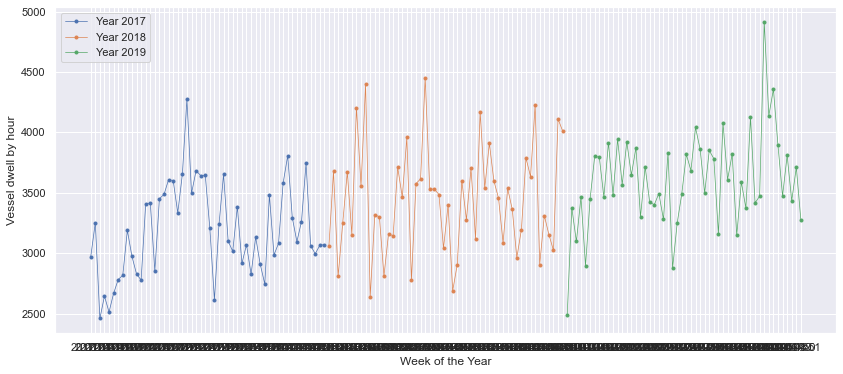

In [28]:
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(week_df2017['VESSEL_DWELL'].apply(np.sum, axis=0)[:52],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2017')
ax.plot(week_df2018['VESSEL_DWELL'].apply(np.sum, axis=0)[:52],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2018')
ax.plot(week_df2019['VESSEL_DWELL'].apply(np.sum, axis=0)[:52],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2019')
ax.set_xlabel('Week of the Year')
ax.set_ylabel('Number of Vessel dwell')
ax.legend()

### _Plot incoming sum_of_teu in time series_

In [29]:
# Dataset for discharge teu (increase of teu) and load teu (decrease of teu)
load_df = df2[df2['EVENT_C'] == 'LOAD']
disc_df = df2[df2['EVENT_C'] == 'DISC']

In [30]:
# Using disc_df as incoming teu
# Comparing sum of TEU across a years timeframe per weekly time series 
# Locate time series by year
disc_df_2017 = disc_df.loc['2017']
disc_df_2018 = disc_df.loc['2018']
disc_df_2019 = disc_df.loc['2019']

In [31]:
week_disc_df2017 = disc_df_2017.groupby(['ARRIVAL_WEEK'])
week_disc_df2018 = disc_df_2018.groupby(['ARRIVAL_WEEK'])
week_disc_df2019 = disc_df_2019.groupby(['ARRIVAL_WEEK'])

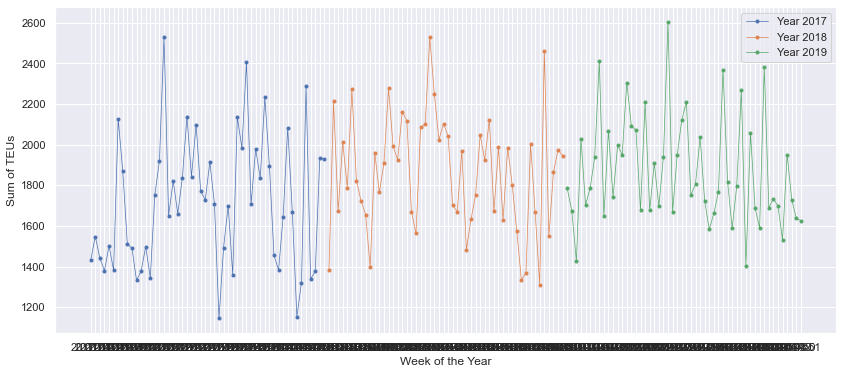

In [32]:
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(week_df2017['SUMOFTEU_Q'].apply(np.sum, axis=0)[:52],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2017')
ax.plot(week_df2018['SUMOFTEU_Q'].apply(np.sum, axis=0)[:52],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2018')
ax.plot(week_df2019['SUMOFTEU_Q'].apply(np.sum, axis=0)[:52],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2019')
ax.set_xlabel('Week of the Year')
ax.set_ylabel('Sum of TEUs')
ax.legend()

In [33]:
# Check weekly arrival sum of teu in figures
week_disc_df = disc_df.groupby(['ARRIVAL_WEEK'])

Text(0, 0.5, 'Sum of TEU')

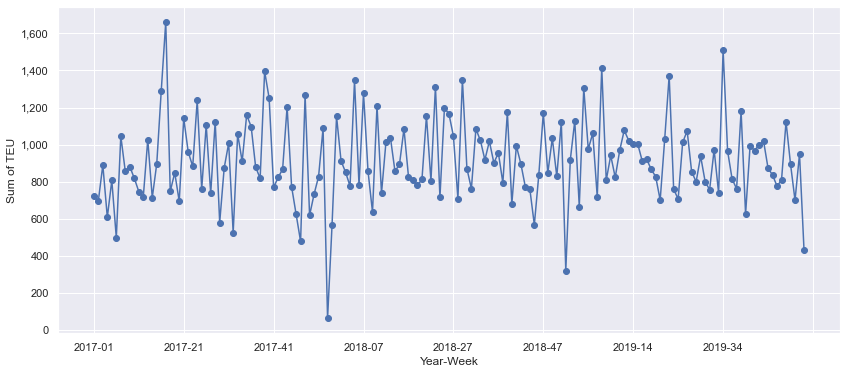

In [34]:
fig, ax = plt.subplots(figsize=(14,6))
ax = (week_disc_df['SUMOFTEU_Q'].apply(np.sum, axis=0)).plot(marker='o', linestyle ='-')
ax.set_xlabel('Year-Week')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel('Sum of TEU')

In [35]:
vol_week = week_disc_df['SUMOFTEU_Q'].apply(np.sum, axis=0)
vol_week = pd.DataFrame(data = vol_week.values, index = vol_week.index, columns=['Volume of TEU'])
vol_week

,Volume of TEU
ARRIVAL_WEEK,
2017-01,723.00
2017-02,696.00
2017-03,890.00
2017-04,608.50
2017-05,807.00
...,...
2019-48,1123.00
2019-49,895.00
2019-50,700.00


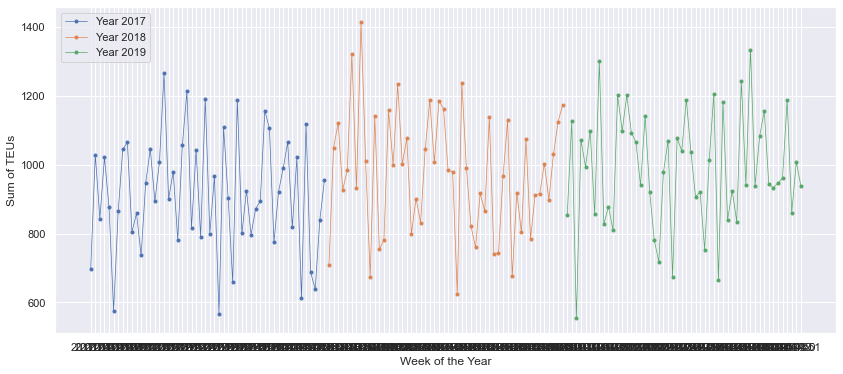

In [36]:
# 2-day moving Average - Sum of TEU per weekly time series 
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(week_disc_df2017['SUMOFTEU_Q_2'].apply(np.sum, axis=0)[:52],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2017')
ax.plot(week_disc_df2018['SUMOFTEU_Q_2'].apply(np.sum, axis=0)[:52],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2018')
ax.plot(week_disc_df2019['SUMOFTEU_Q_2'].apply(np.sum, axis=0)[:52],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2019')
ax.set_xlabel('Week of the Year')
ax.set_ylabel('Sum of TEUs')
ax.legend()

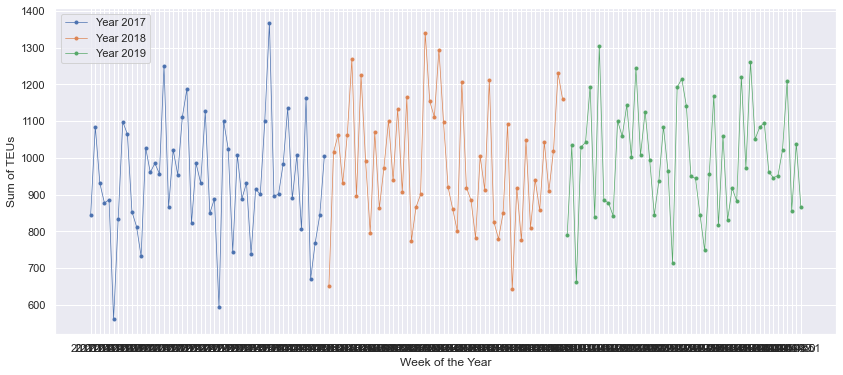

In [37]:
# 3-day moving Average - Sum of TEU per weekly time series 
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(week_disc_df2017['SUMOFTEU_Q_3'].apply(np.sum, axis=0)[:52],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2017')
ax.plot(week_disc_df2018['SUMOFTEU_Q_3'].apply(np.sum, axis=0)[:52],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2018')
ax.plot(week_disc_df2019['SUMOFTEU_Q_3'].apply(np.sum, axis=0)[:52],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2019')
ax.set_xlabel('Week of the Year')
ax.set_ylabel('Sum of TEUs')
ax.legend()

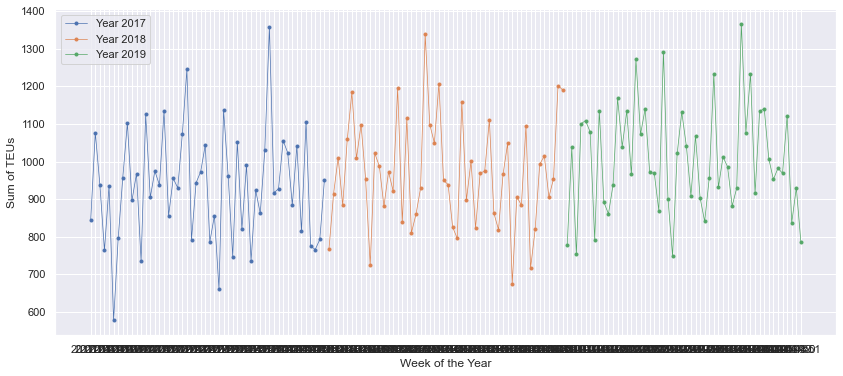

In [38]:
# 5-day moving Average - Sum of TEU per weekly time series 

fig, ax = plt.subplots(figsize=(14,6))
ax.plot(week_disc_df2017['SUMOFTEU_Q_5'].apply(np.sum, axis=0)[:52],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2017')
ax.plot(week_disc_df2018['SUMOFTEU_Q_5'].apply(np.sum, axis=0)[:52],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2018')
ax.plot(week_disc_df2019['SUMOFTEU_Q_5'].apply(np.sum, axis=0)[:52],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2019')
ax.set_xlabel('Week of the Year')
ax.set_ylabel('Sum of TEUs')
ax.legend()

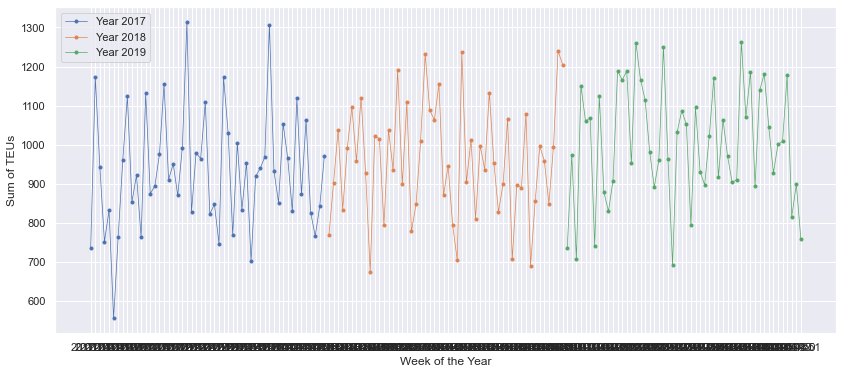

In [39]:
# 7-day moving Average - Sum of TEU per weekly time series 

fig, ax = plt.subplots(figsize=(14,6))
ax.plot(week_disc_df2017['SUMOFTEU_Q_7'].apply(np.sum, axis=0)[:52],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2017')
ax.plot(week_disc_df2018['SUMOFTEU_Q_7'].apply(np.sum, axis=0)[:52],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2018')
ax.plot(week_disc_df2019['SUMOFTEU_Q_7'].apply(np.sum, axis=0)[:52],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2019')
ax.set_xlabel('Week of the Year')
ax.set_ylabel('Sum of TEUs')
ax.legend()

### _Plot container dwell in time series_

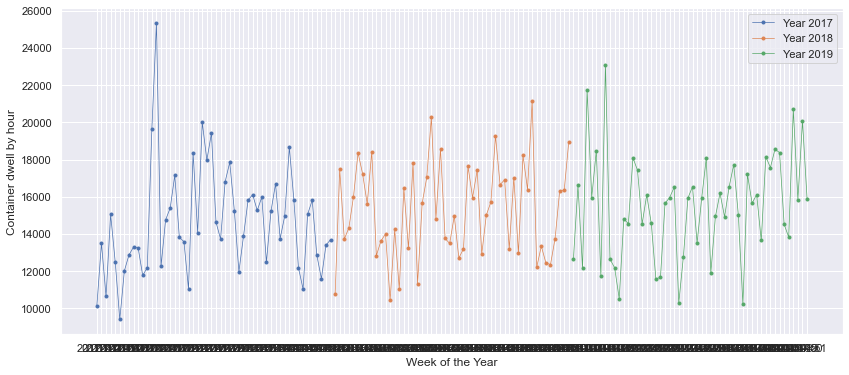

In [40]:
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(week_disc_df2017['CONTAINER_DWELL'].apply(np.sum, axis=0)[:52],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2017')
ax.plot(week_disc_df2018['CONTAINER_DWELL'].apply(np.sum, axis=0)[:52],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2018')
ax.plot(week_disc_df2019['CONTAINER_DWELL'].apply(np.sum, axis=0)[:52],\
        marker='.',linestyle='-',linewidth=0.7, label='Year 2019')
ax.set_xlabel('Week of the Year')
ax.set_ylabel('Number of Container dwell')
ax.legend()

### _Features Analysis on average target labels_

In [41]:
# Define top load country
df2['LOAD_COUNTRY'].value_counts().head(10) / 100

Indonesia        39.38
China            34.89
Malaysia         25.33
Thailand         17.52
Viet Nam         16.84
India            15.70
Australia        10.55
United States    10.28
Japan            10.15
Bangladesh        8.85
Name: LOAD_COUNTRY, dtype: float64

In [42]:
top_load_country =  ['Indonesia','China','Malaysia','Thailand','Viet Nam','India']

In [43]:
# Define top discharge country
df2['DISC_COUNTRY'].value_counts().head(10) / 100

Indonesia        19.85
Australia        17.44
China            16.70
India            16.70
United States    16.26
Malaysia         15.12
Viet Nam         12.07
Thailand         11.22
Japan             8.10
Italy             7.08
Name: DISC_COUNTRY, dtype: float64

In [44]:
top_disc_country = ['Indonesia','Australia','China','India','United States','Malaysia']

#### Vessel dwell

In [45]:
def get_vessel_dwell(df):  
    vessel_dwell=df.groupby(by=['DISC_COUNTRY','LOAD_COUNTRY','VESSEL_TYPE_M1','DIRECTION_C1',
                            'ARRIVAL_DATE','WEEK_OF_YEAR'])['VESSEL_DWELL'].mean().reset_index()      
    return vessel_dwell

In [46]:
vessel_dwell = get_vessel_dwell(df2)
vessel_dwell = vessel_dwell.sort_values('ARRIVAL_DATE')
vessel_dwell = vessel_dwell.set_index('ARRIVAL_DATE')

In [47]:
# Create top load country list
vessel_dwell_load_country = vessel_dwell[vessel_dwell['LOAD_COUNTRY'].isin(top_load_country)]

# Create top discharge country list
vessel_dwell_disc_country = vessel_dwell[vessel_dwell['DISC_COUNTRY'].isin(top_disc_country)]

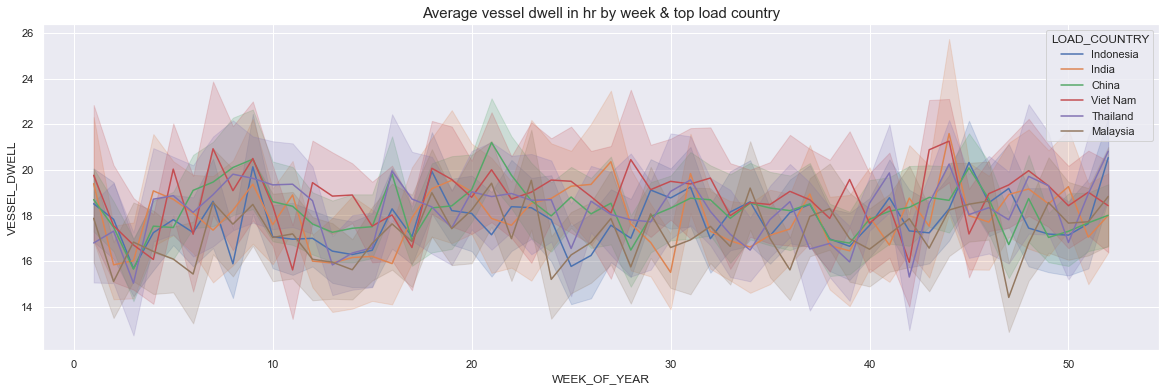

In [48]:
# 'LOAD_COUNTRY'
get_line(vessel_dwell_load_country,vessel_dwell_load_country['WEEK_OF_YEAR'],vessel_dwell_load_country['VESSEL_DWELL'],
         HUE = 'LOAD_COUNTRY' ,TITLE='Average vessel dwell in hr by week & top load country')

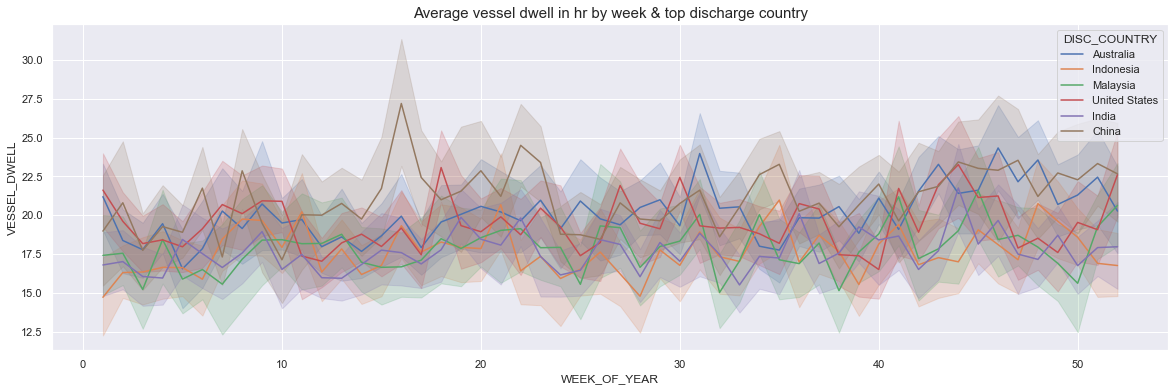

In [49]:
# 'DISC_COUNTRY'
get_line(vessel_dwell_disc_country,vessel_dwell_disc_country['WEEK_OF_YEAR'],vessel_dwell_disc_country['VESSEL_DWELL'],
         HUE = 'DISC_COUNTRY' ,TITLE='Average vessel dwell in hr by week & top discharge country')

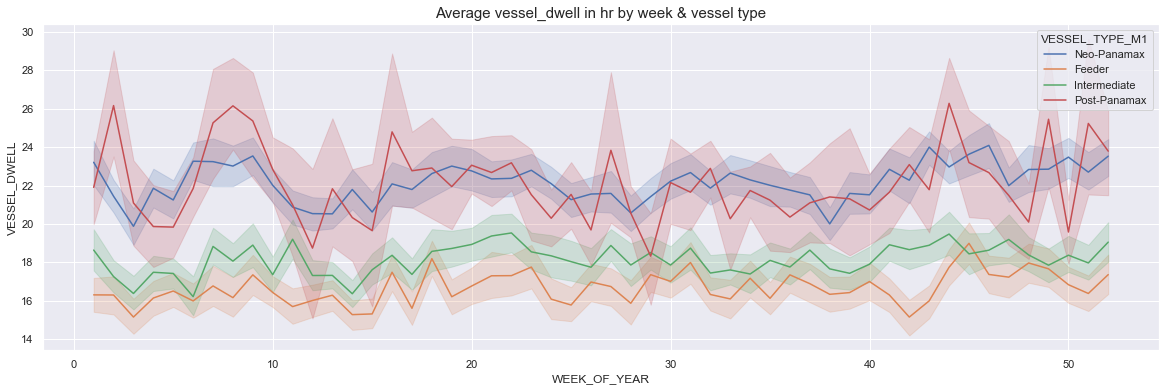

In [50]:
# 'VESSEL_TYPE_M1'
get_line(vessel_dwell,vessel_dwell['WEEK_OF_YEAR'],vessel_dwell['VESSEL_DWELL'],
         HUE='VESSEL_TYPE_M1',TITLE='Average vessel_dwell in hr by week & vessel type')

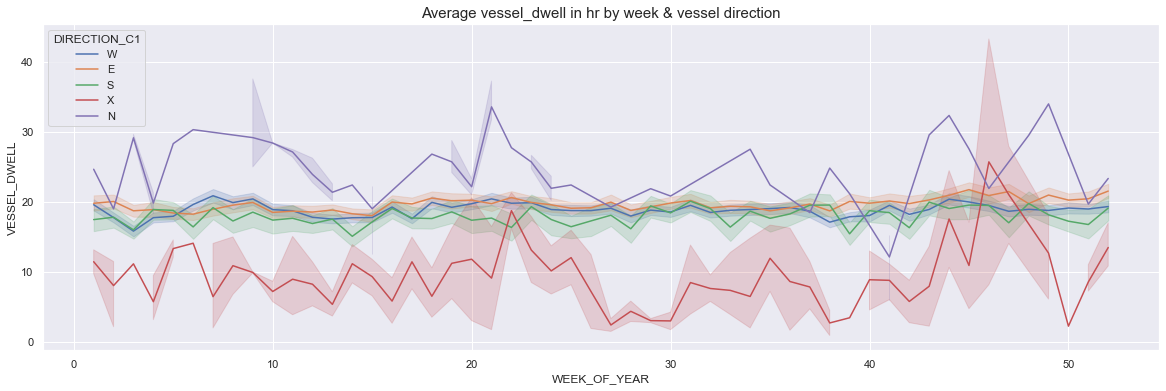

In [51]:
# 'DIRECTION_C1'
get_line(vessel_dwell,vessel_dwell['WEEK_OF_YEAR'],vessel_dwell['VESSEL_DWELL'],
         HUE='DIRECTION_C1',TITLE='Average vessel_dwell in hr by week & vessel direction')

#### Sum of TEU

In [52]:
# Groupby SUMOFTEU_Q.mean(average)
def get_sumofteu(df):
    sumofteu=df.groupby(by=['EVENT_C','CNTR_STATUS_C','DISC_COUNTRY','LOAD_COUNTRY',
                            'VESSEL_TYPE_M1','SERVICE_C1','DIRECTION_C1','OPR_GROUP_C',
                            'ARRIVAL_DATE','ARRIVAL_WEEK','ARRIVAL_MONTH','WEEK_OF_YEAR','MONTH_OF_YEAR'])['SUMOFTEU_Q'].mean().reset_index()
    return sumofteu

In [53]:
sumofteu = get_sumofteu(disc_df)
sumofteu = sumofteu.sort_values('ARRIVAL_DATE')
sumofteu = sumofteu.set_index('ARRIVAL_DATE')

In [54]:
# Create top load country list
sumofteu_load_country = sumofteu[sumofteu['LOAD_COUNTRY'].isin(top_load_country)]

# Create top discharge country list
sumofteu_disc_country = sumofteu[sumofteu['DISC_COUNTRY'].isin(top_disc_country)]

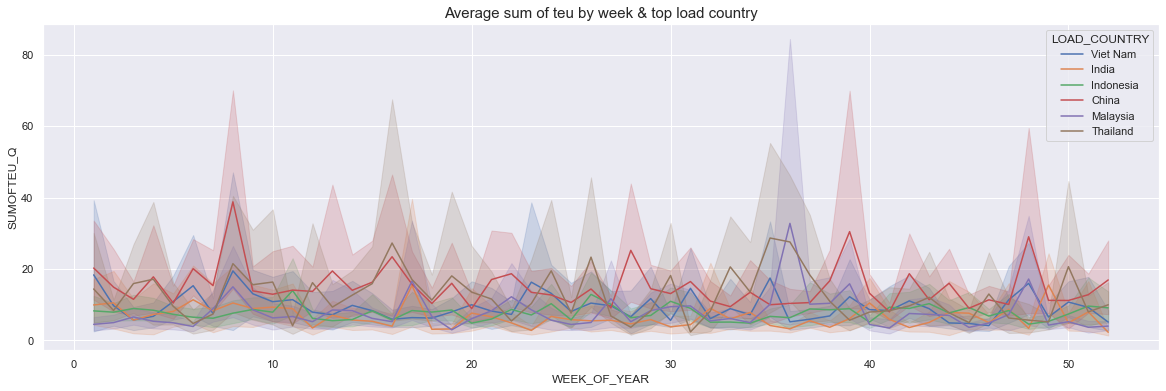

In [55]:
# 'LOAD_COUNTRY'
get_line(sumofteu_load_country,sumofteu_load_country['WEEK_OF_YEAR'],sumofteu_load_country['SUMOFTEU_Q'],
         HUE = 'LOAD_COUNTRY' ,TITLE='Average sum of teu by week & top load country')

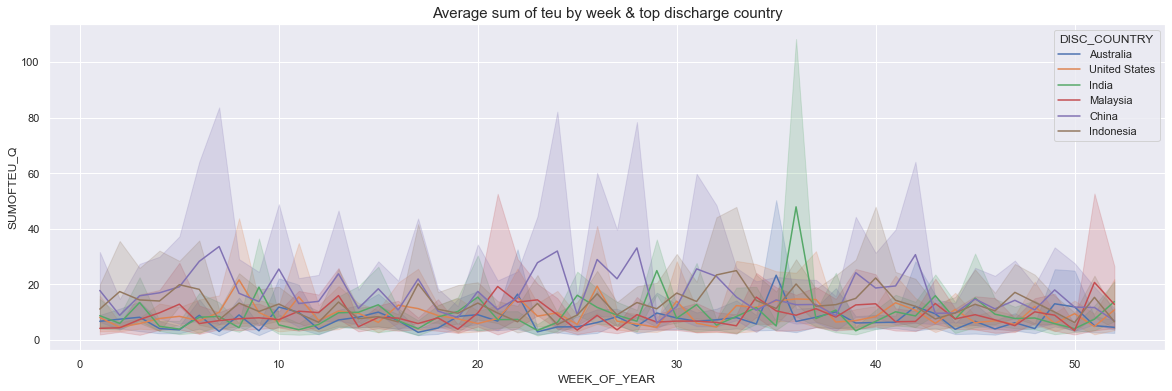

In [56]:
# 'DISC_COUNTRY'
get_line(sumofteu_disc_country,sumofteu_disc_country['WEEK_OF_YEAR'],sumofteu_disc_country['SUMOFTEU_Q'],
         HUE = 'DISC_COUNTRY' ,TITLE='Average sum of teu by week & top discharge country')

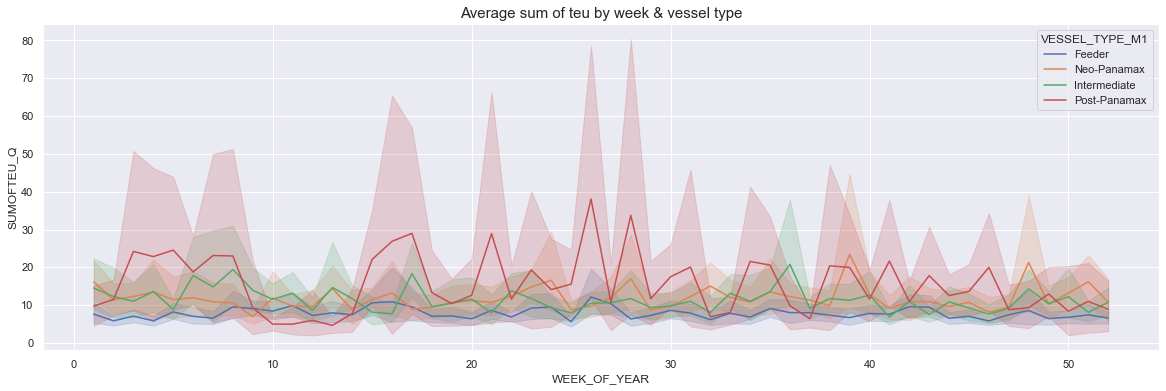

In [57]:
# 'VESSEL_TYPE_M1'
get_line(sumofteu,sumofteu['WEEK_OF_YEAR'],sumofteu['SUMOFTEU_Q'],
         HUE='VESSEL_TYPE_M1',TITLE='Average sum of teu by week & vessel type')

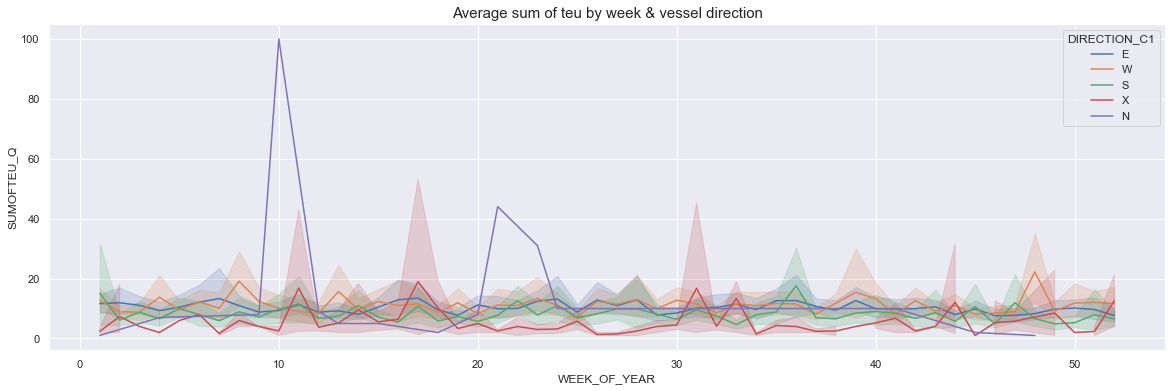

In [58]:
# 'DIRECTION_C1'
get_line(sumofteu,sumofteu['WEEK_OF_YEAR'],sumofteu['SUMOFTEU_Q'],
         HUE='DIRECTION_C1',TITLE='Average sum of teu by week & vessel direction')

#### Container dwell

In [59]:
def get_container_dwell(df):    
    container_dwell=df.groupby(by=['DISC_COUNTRY','LOAD_COUNTRY','VESSEL_TYPE_M1','DIRECTION_C1',
                            'ARRIVAL_DATE','WEEK_OF_YEAR'])['CONTAINER_DWELL'].mean().reset_index()
    return container_dwell

In [60]:
container_dwell = get_container_dwell(disc_df)
container_dwell = container_dwell.sort_values('ARRIVAL_DATE')
container_dwell = container_dwell.set_index('ARRIVAL_DATE')

In [61]:
# Create top load country list
container_dwell_load_country = container_dwell[container_dwell['LOAD_COUNTRY'].isin(top_load_country)]

# Create top discharge country list
container_dwell_disc_country = container_dwell[container_dwell['DISC_COUNTRY'].isin(top_disc_country)]

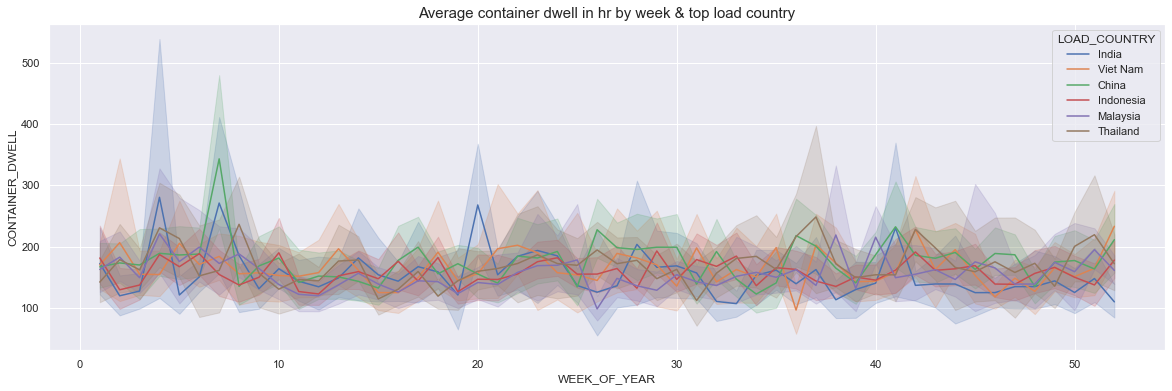

In [62]:
# 'LOAD_COUNTRY'
get_line(container_dwell_load_country,container_dwell_load_country['WEEK_OF_YEAR'],container_dwell_load_country['CONTAINER_DWELL'],
         HUE = 'LOAD_COUNTRY' ,TITLE='Average container dwell in hr by week & top load country')

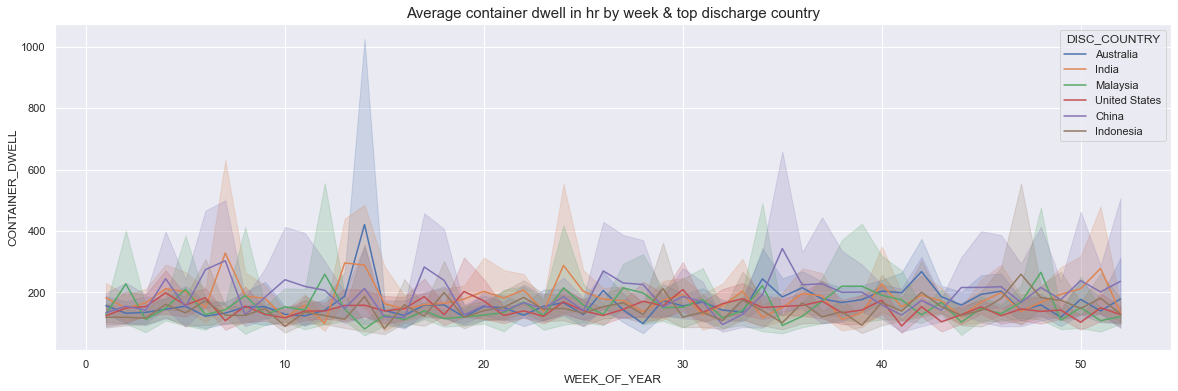

In [63]:
# 'DISC_COUNTRY'
get_line(container_dwell_disc_country,container_dwell_disc_country['WEEK_OF_YEAR'],container_dwell_disc_country['CONTAINER_DWELL'],
         HUE = 'DISC_COUNTRY' ,TITLE='Average container dwell in hr by week & top discharge country')

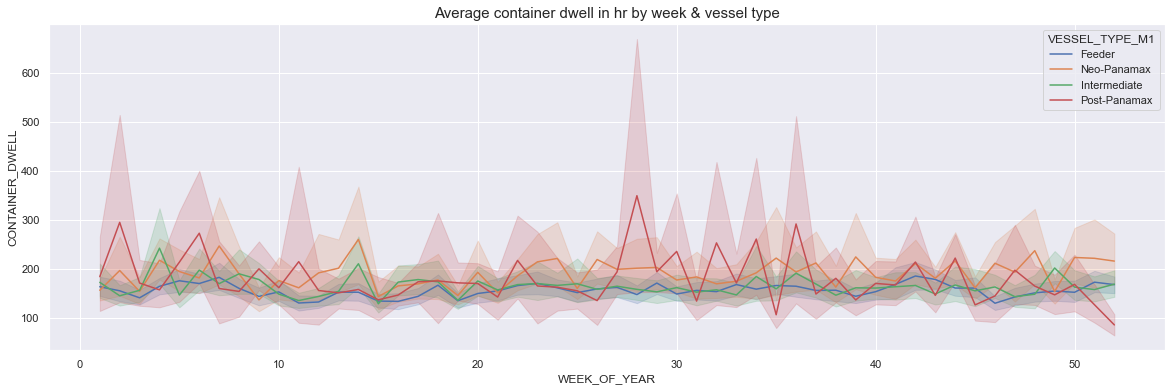

In [64]:
# 'VESSEL_TYPE_M1'
get_line(container_dwell,container_dwell['WEEK_OF_YEAR'],container_dwell['CONTAINER_DWELL'],
         HUE='VESSEL_TYPE_M1',TITLE='Average container dwell in hr by week & vessel type')

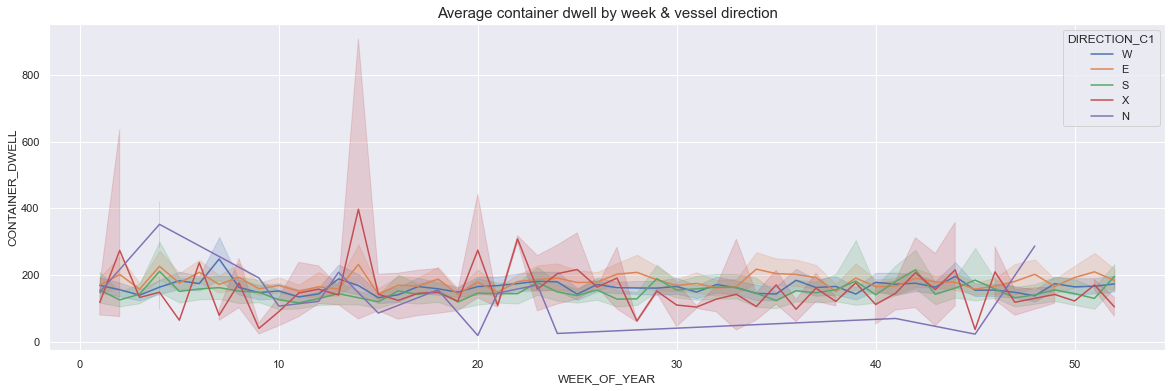

In [65]:
# 'DIRECTION_C1'
get_line(container_dwell,container_dwell['WEEK_OF_YEAR'],container_dwell['CONTAINER_DWELL'],
         HUE='DIRECTION_C1',TITLE='Average container dwell by week & vessel direction')

<AxesSubplot:>

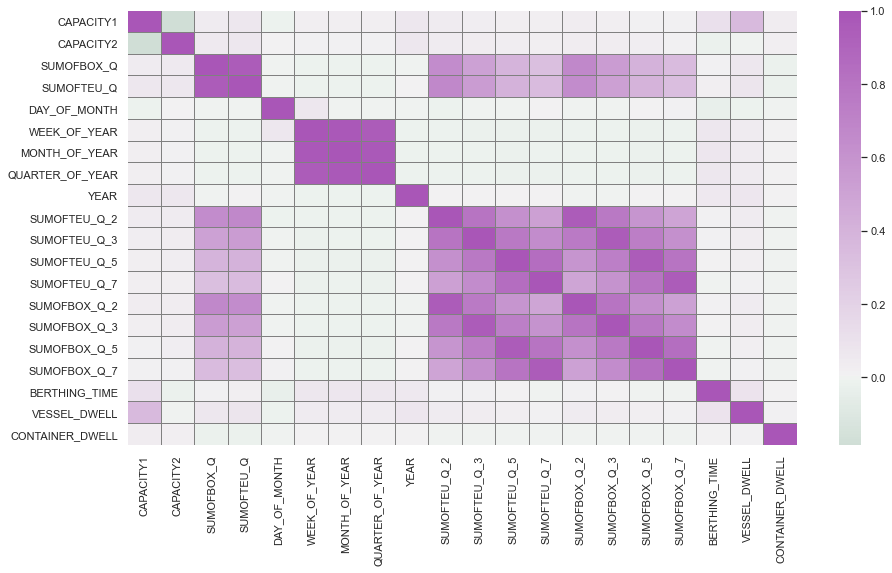

In [66]:
# Check correlation
fig, ax = plt.subplots(figsize = (15,8))
mycmap = sns.diverging_palette(145, 300, s = 60, as_cmap = True)
sns.heatmap(data = df2.corr(), center = 0.0, square = False, cmap = mycmap, linewidths = 0.01, 
            linecolor = 'gray')

#### Results:

After detailed features engineering and analysis, we narrow down to below three target labels for modelling.

- "SUMOFTEU_Q_NEXTWEEK"
- "VESSEL_DWELL"
- "CONTAINER_DWELL"

## 5. Machine Learning Model <a class="anchor" id="5.MachineLearningModel"></a>

#### Machine learning utils

In [118]:
# Regression score metrics

def print_metrics(y_true, y_predicted, n_parameters):
    
    r2 = sklm.r2_score(y_true, y_predicted)
    r2_adj = r2 - (n_parameters - 1)/(y_true.shape[0] - n_parameters) * (1 - r2)
    mape=np.mean(np.abs((y_true - y_predicted) / y_true)) * 100
    
    print('Mean Square Error      = ' + str(sklm.mean_squared_error(y_true, y_predicted)))
    print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(y_true, y_predicted)))
    print('Median Absolute Error  = ' + str(sklm.median_absolute_error(y_true, y_predicted)))
    print('R^2 / Accuracy         = ' + str(r2))
    print('Adjusted R^2           = ' + str(r2_adj)) 
    print('Mean Absolute Percentage Error  =' + str(mape))

In [119]:
# Classifier score metrics

def score_model(probs, threshold):
    return np.array([1 if x > threshold else 0 for x in probs[:,1]])

def print_metrics(labels, probs, threshold):
    scores = score_model(probs, threshold)
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion matrix')
    print('                 Actual negative    Actual positive')
    print('Score negative    %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Score positive    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('')
    print('Accuracy        %0.2f' % sklm.accuracy_score(labels, scores))
    print('AUC             %0.2f' % sklm.roc_auc_score(labels, probs[:,1]))
    print('Macro precision %0.2f' % float((float(metrics[0][0]) + float(metrics[0][1]))/2.0))
    print('Macro recall    %0.2f' % float((float(metrics[1][0]) + float(metrics[1][1]))/2.0))
    print(' ')
    print('           Negative     Positive')
    print('Num case   %6d'   % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])

In [120]:

def plot_auc(labels, probs):
    ## Compute the false positive rate, true positive rate
    ## and threshold along with the AUC
    fpr, tpr, threshold = sklm.roc_curve(labels, probs[:,1])
    auc = sklm.auc(fpr, tpr)
    
    ## Plot the result
    plt.figure(figsize=(10,6))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show() 

In [121]:
    
def get_count_confusion_metrics(model, x , y):
    
    plot_confusion_matrix(model, x , y)  
    fig = plt.gcf().set_size_inches(12, 6)

### AUTO-ARIMA Model for SUMOFTEU_Q weekly prediction

#### Pre-processing data for modeling

Using disc_df discharge dataset for modeling

In [71]:
disc_df1 = disc_df.copy()

In [72]:
disc_df1.reset_index(inplace=True)

In [73]:
# Groupby weekly basis
disc_df1 = disc_df1.groupby(['ARRIVAL_WEEK']).sum()

In [76]:
disc_df1

,CAPACITY1,CAPACITY2,SUMOFBOX_Q,SUMOFTEU_Q,DAY_OF_MONTH,WEEK_OF_YEAR,MONTH_OF_YEAR,QUARTER_OF_YEAR,YEAR,SUMOFTEU_Q_2,SUMOFTEU_Q_3,SUMOFTEU_Q_5,SUMOFTEU_Q_7,SUMOFBOX_Q_2,SUMOFBOX_Q_3,SUMOFBOX_Q_5,SUMOFBOX_Q_7,BERTHING_TIME,VESSEL_DWELL,CONTAINER_DWELL
ARRIVAL_WEEK,,,,,,,,,,,,,,,,,,,,
2017-01,423800.0,473000.0,484,723.00,287,375,69,69,139173,696.000,845.500000,843.70,735.107143,454.0,562.333333,550.2,487.428571,80.450000,1168.916667,10154.733333
2017-02,556200.0,321100.0,462,696.00,948,156,88,88,177496,1029.500,1084.666667,1076.60,1172.571429,667.5,729.000000,703.4,748.571429,173.650000,1507.883333,13497.116667
2017-03,442500.0,499400.0,559,890.00,1421,223,78,78,157326,844.000,930.333333,938.80,942.785714,544.5,593.333333,598.0,604.285714,69.550000,1305.000000,10643.133333
2017-04,426400.0,518200.0,427,608.50,1902,295,75,75,151275,1021.875,877.250000,763.95,752.714286,666.5,578.000000,506.6,499.142857,104.516667,1338.733333,15053.133333
2017-05,480700.0,490200.0,571,807.00,1129,358,114,74,149258,877.375,885.916667,935.75,832.321429,568.0,581.333333,609.2,544.428571,91.133333,1368.716667,12506.016667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-48,762700.0,745700.0,662,1123.00,405,4936,1212,404,203919,1188.500,1209.416667,1121.95,1178.321429,727.5,777.333333,729.6,767.142857,509.450000,2258.200000,20693.283333
2019-49,505300.0,669000.0,618,895.00,929,4189,1008,336,169596,860.625,856.250000,837.15,816.250000,566.5,580.000000,557.4,545.000000,228.166667,1517.866667,15847.583333
2019-50,669700.0,646800.0,491,700.00,1586,4477,1056,352,177672,1008.625,1039.083333,929.95,898.821429,657.0,689.333333,614.6,591.000000,276.116667,1894.133333,20070.150000


#### ADF test for stationarity of time series

In [77]:
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(disc_df1.SUMOFTEU_Q)

(0.01, False)

Results:

From the above result (0.01, False), we can conclude that the data is non-stationary. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series to make the data stationary while building the Auto ARIMA model.

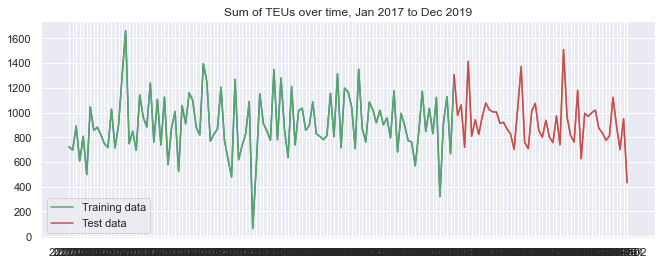

In [78]:
# Pre-Check train test result
train = disc_df1.SUMOFTEU_Q[:110]  # 70% train
test = disc_df1.SUMOFTEU_Q[-50:]   # 30% test

plt.plot(train)
plt.plot(test)
plt.plot(train, label = 'Training data')
plt.plot(test, label = 'Test data')
plt.title('Sum of TEUs over time, Jan 2017 to Dec 2019')
plt.legend()
plt.show()

#### Model training

In [79]:
arima_model = auto_arima(train,start_p=0, d=1, start_q=0,
                        max_p=5, max_d=5, max_q=5, start_P=0,
                        D=1, start_Q=0, max_P=5, max_D=5, max_Q=5,
                        m=12, seasonal=True, error_action='warn', trace=True,
                        supress_warning=True, stepwise=True, random_state=20, 
                        n_fits = 50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1485.219, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1423.865, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1447.293, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1421.867, Time=0.25 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=1420.448, Time=0.39 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=1416.753, Time=0.91 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=1414.416, Time=1.65 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=4.41 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=2.87 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=inf, Time=1.59 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=inf, Time=2.45 sec
 ARIMA(1,1,1)(5,1,0)[12]             : AIC=inf, Time=3.16 sec
 ARIMA(0,1,1)(5,1,0)[12]             : AIC=inf, Time=2.76 sec
 ARIMA(2,1,1)(5,1,0)[12]             : AIC=1383.742, T

#### Prediction on test set

In [80]:
sumofteu_prediction = pd.DataFrame(arima_model.predict(n_periods=50),index=test.index)
sumofteu_prediction.columns = ['Predicted_sumofTEU']
sumofteu_prediction

,Predicted_sumofTEU
ARRIVAL_WEEK,
2019-03,1038.126567
2019-04,1039.410963
2019-05,658.612501
2019-06,767.122987
2019-07,966.547722
2019-08,980.242440
2019-09,920.137351
2019-10,658.159068
2019-11,881.772468


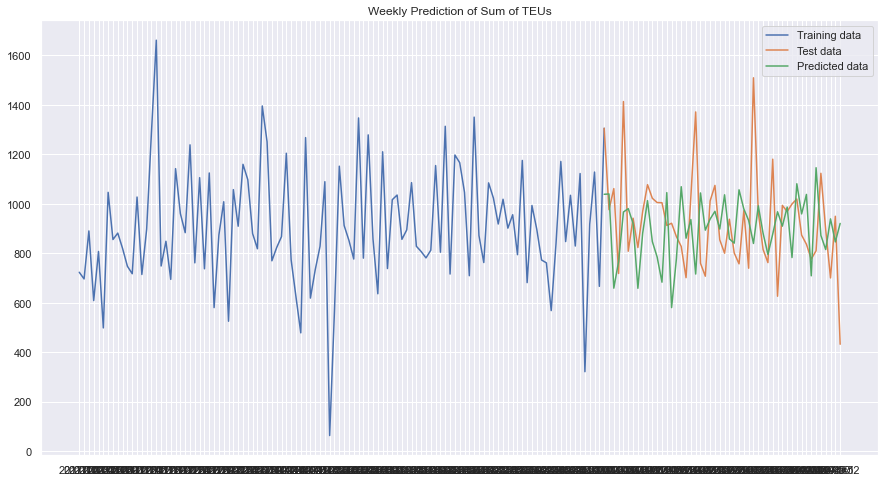

In [81]:
# Plot prediction result
plt.figure(figsize=(15,8))
plt.plot(train, label = 'Training data')
plt.plot(test, label = 'Test data')
plt.plot(sumofteu_prediction, label = 'Predicted data')
plt.legend()
plt.title('Weekly Prediction of Sum of TEUs')
plt.show()

#### Results:
Based on the result from auto-ARIMA, the Best model:  ARIMA(2,1,1)(5,1,0)[12] 

#### Check performance metrics

In [90]:
print_metrics(test, sumofteu_prediction['Predicted_sumofTEU'], 49)

Mean Square Error      = 58791.421283111995
Root Mean Square Error = 242.46942339831634
Mean Absolute Error    = 187.67687382594366
Median Absolute Error  = 162.26031553698112
R^2 / Accuracy         = -0.5206098039793245
Adjusted R^2           = -73.50988039498691
Mean Absolute Percentage Error  =20.996727760039818


### Classifier Model for vessel dwell

#### Pre-processing data
Using df2 (full variables) for modeling

(array([6.500e+01, 2.060e+02, 2.270e+02, 4.320e+02, 9.680e+02, 1.581e+03,
        2.375e+03, 3.159e+03, 3.335e+03, 3.358e+03, 3.037e+03, 2.557e+03,
        1.965e+03, 1.509e+03, 1.016e+03, 8.240e+02, 5.130e+02, 3.840e+02,
        2.340e+02, 1.670e+02, 6.500e+01, 6.600e+01, 2.600e+01, 1.200e+01,
        1.000e+01, 4.000e+00, 4.000e+00, 4.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0.08333333,  2.01888889,  3.95444444,  5.89      ,  7.82555556,
         9.76111111, 11.69666667, 13.63222222, 15.56777778, 17.50333333,
        19.43888889, 21.37444444, 23.31      , 25.24555556, 27.18111111,
        29.11666667, 31.05222222, 32.98777778, 34.92333333, 36.85888889,
        38.79444444, 40.73      , 42.66555556, 44.60111111, 46.53666667,
        48.47222222, 50.40777778, 52.34333333, 54.27888889, 56.21444444,
        58.15      ]),
 <BarContainer object of 30 artists>)

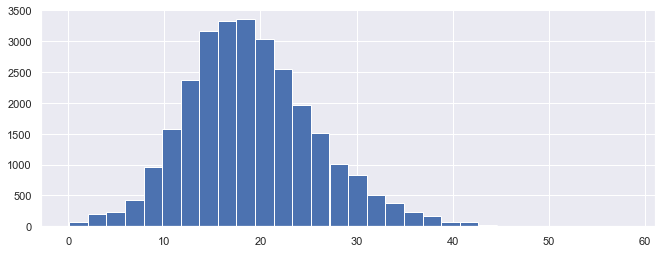

In [91]:
# Check distribution of vessel dwell 
plt.hist(data=df2, x='VESSEL_DWELL', bins=30)

In [92]:
# Check vessel distribution
df2['VESSEL_TYPE_M1'].value_counts()/np.float(len(df2))

<ipython-input-92-51344a5ae752>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df2['VESSEL_TYPE_M1'].value_counts()/np.float(len(df2))


Feeder          0.343403
Intermediate    0.305971
Neo-Panamax     0.298498
Post-Panamax    0.052128
Name: VESSEL_TYPE_M1, dtype: float64

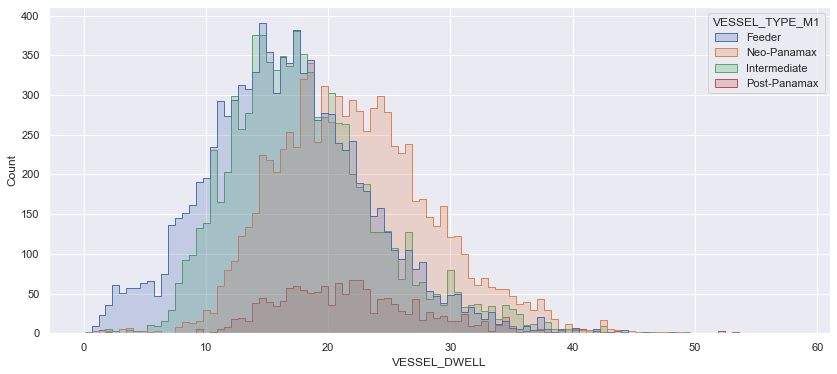

In [93]:
# Plot histogram of vessel dwell time and count of vessel type
get_hist(df2,X = 'VESSEL_DWELL' , HUE='VESSEL_TYPE_M1', TITLE=None)

In [284]:
# Create binary label base on 75 percentile value @ 23hr
df2['VESSEL_DWELL_STATUS'] = np.where(df2['VESSEL_DWELL'] > 23, 'Above 23h', 'Below 23h')

In [95]:
# Filter target vessel type (if its running for full dataset)
# ves_dwell_df = df2[df2['VESSEL_TYPE_M1'] == 'Feeder']

In [286]:
# Prepare drop list
drop_list = ['EVENT_C', 'CNTR_STATUS_C','ABBR_VESSEL_M1','BTR1','ATD1', 'ATU1', 'SERVICE_C1','ABBR_VESSEL_M2','BTR2', 'ATD2', 
             'ATU2','LINE_C2_GROUP', 'SERVICE_C2', 'DIRECTION_C2', 'CAPACITY2','DERIVED_CNTR_PURP_C','OPR_GROUP_C', 
             'SUMOFBOX_Q','QUARTER_OF_YEAR', 'YEAR','VESSEL_TYPE_M1', 'VESSEL_TYPE_M2','SUMOFBOX_Q_2', 
             'SUMOFBOX_Q_3','SUMOFBOX_Q_5', 'SUMOFBOX_Q_7']

In [287]:
# Drop variables
ves_dwell_df = df2.drop(drop_list, axis = 1)

In [288]:
# Select features

cat_col = ['DISC_PORT1_C', 'LOAD_PORT_C','LINE_C1_GROUP','DIRECTION_C1','ARRIVAL_MONTH','ARRIVAL_WEEK', 
           'DISC_COUNTRY','LOAD_COUNTRY','CONTAINER_LOAD_VESSEL_TYPE','VESSEL_DWELL_STATUS']

num_col = ['CAPACITY1', 'SUMOFTEU_Q','DAY_OF_MONTH', 'MONTH_OF_YEAR','SUMOFTEU_Q_2', 
           'SUMOFTEU_Q_3','SUMOFTEU_Q_5', 'SUMOFTEU_Q_7', 'BERTHING_TIME', 'VESSEL_DWELL','CONTAINER_DWELL']

#### Random over-sampling for imbalanced classes of target label

In [289]:
# Check distribution for target label
ves_dwell_df['VESSEL_DWELL_STATUS'].value_counts() / len(ves_dwell_df)

Below 23h    0.743844
Above 23h    0.256156
Name: VESSEL_DWELL_STATUS, dtype: float64

In [290]:
ves_dwell_df.VESSEL_DWELL_STATUS.value_counts()

Below 23h    20905
Above 23h     7199
Name: VESSEL_DWELL_STATUS, dtype: int64

In [297]:
# Define dataset
class_0 = ves_dwell_df.drop('VESSEL_DWELL_STATUS', axis = 1)
class_1 = ves_dwell_df.VESSEL_DWELL_STATUS     

# Define random oversampling strategy
ros = RandomOverSampler(random_state=42)
class_0_ros, class_1_ros = ros.fit_resample(class_0 , class_1)

# Merge data as rs (resampled dataframe)
rs_df = pd.concat([class_0_ros, class_1_ros], axis=1)

# Check distribution of class after resampling
rs_df['VESSEL_DWELL_STATUS'].value_counts()/len(rs_df['VESSEL_DWELL_STATUS'])
rs_df['VESSEL_DWELL_STATUS'].value_counts()

Above 23h    20905
Below 23h    20905
Name: VESSEL_DWELL_STATUS, dtype: int64

In [298]:
rs_df = rs_df.set_index('WEEK_OF_YEAR')

In [299]:
# Convert 'VESSEL_DWELL_STATUS' into Above 23h=1, Below 23h=0 
rs_df['VESSEL_DWELL_STATUS'] = np.where(rs_df['VESSEL_DWELL_STATUS'] == 'Above 23h', 1, 0)

In [300]:
rs_df

,DISC_PORT1_C,LOAD_PORT_C,LINE_C1_GROUP,DIRECTION_C1,CAPACITY1,SUMOFTEU_Q,ARRIVAL_WEEK,ARRIVAL_MONTH,DAY_OF_MONTH,MONTH_OF_YEAR,DISC_COUNTRY,LOAD_COUNTRY,CONTAINER_LOAD_VESSEL_TYPE,SUMOFTEU_Q_2,SUMOFTEU_Q_3,SUMOFTEU_Q_5,SUMOFTEU_Q_7,BERTHING_TIME,VESSEL_DWELL,CONTAINER_DWELL,VESSEL_DWELL_STATUS
WEEK_OF_YEAR,,,,,,,,,,,,,,,,,,,,,
52,IDSRG,USNYC,L376,S,1000.0,15.0,2017-01,2017-01,1,1,Indonesia,United States,Feeder,10.5,11.666667,11.00,10.142857,22.983333,8.700000,64.900000,0
52,ITGOA,BDCGP,L391,W,9000.0,7.0,2017-01,2017-01,1,1,Italy,Bangladesh,Neo-Panamax,5.0,4.333333,5.60,19.571429,1.500000,15.033333,57.150000,0
52,FRLEH,JPTYO,L367,W,13000.0,6.0,2017-01,2017-01,1,1,France,Japan,Neo-Panamax,8.0,7.000000,7.20,5.571429,1.833333,24.450000,116.583333,1
52,AEJEA,JPSMZ,L391,W,9000.0,2.0,2017-01,2017-01,1,1,United Arab Emirates,Japan,Neo-Panamax,1.5,1.333333,2.80,2.714286,1.916667,27.233333,144.700000,1
52,KEMBA,VNHPH,L352,W,4000.0,3.0,2017-01,2017-01,1,1,Kenya,Viet Nam,Intermediate,2.5,4.416667,4.25,6.035714,0.500000,11.333333,224.133333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,BEANR,IDSRG,L344,W,14000.0,4.0,2018-33,2018-08,21,8,Belgium,Indonesia,Neo-Panamax,6.0,4.666667,4.00,5.142857,13.283333,26.450000,202.683333,1
38,MTMLA,MYPKG,L367,W,7000.0,16.0,2018-37,2018-09,17,9,Malta,Malaysia,Intermediate,10.5,8.333333,9.80,11.428571,-3.583333,23.950000,125.750000,1
9,GBFXT,KHKOS,L402,E,2000.0,35.0,2018-08,2018-02,27,2,United Kingdom,Cambodia,Post-Panamax,18.5,14.000000,9.00,7.000000,2.333333,27.866667,69.833333,1


#### Define X,y for modeling

In [301]:
# Define X and y using rs_df (over-sampled data)
X = rs_df.drop('VESSEL_DWELL_STATUS', axis = 1)
y = rs_df.VESSEL_DWELL_STATUS 

# Scaling 
sc = StandardScaler()
X_scaled = sc.fit_transform(X[num_col])
X_scaled = pd.DataFrame(X_scaled, columns = num_col)

# Get dummy 
X_dummy = pd.get_dummies(X)
X_dummy.update(X_scaled)

X = X_dummy

# Train-split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state =42)

In [213]:
# Train-Test split 
#X_train = X [:29267]
#X_test = X [-12544:]
#y_train = y [:29267]
#y_test = y [-12544:]

In [302]:
#---------------------- Model training with resampled data-----------------------#

# Train random forest classifier model on training data set
# Initialize randomforest classifier
rf_clf = RandomForestClassifier(random_state = 42)

# Fit the training data
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [303]:
#-------------------------------- Model testing ---------------------------------#

# Predict for X_test data set using the fitted model
y_pred_rf_clf = rf_clf.predict(X_test)

In [304]:
#-------------------------------- Model evaluation ---------------------------------#
# Evaluate model accuracy using fitted y value and actual y_test
# Evaluation metrics to be used - eg. Precision, Recall, confusion matrix, ROC 

# Probabilities prediction on test set
probabilities = rf_clf.predict_proba(X_test)

In [306]:
# Display AUC and confusion matrix
print_metrics((y_test == 1), probabilities, 0.5)

                 Confusion matrix
                 Actual negative    Actual positive
Score negative      5606               665
Score positive       378              5894

Accuracy        0.92
AUC             0.98
Macro precision 0.92
Macro recall    0.92
 
           Negative     Positive
Num case     6271          6272
Precision    0.94          0.90
Recall       0.89          0.94
F1           0.91          0.92


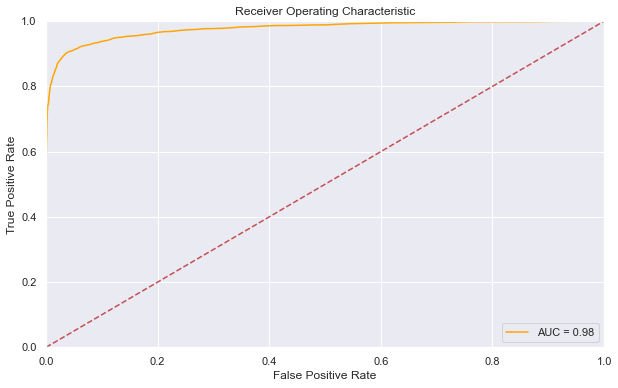

In [307]:
plot_auc((y_test == 1), probabilities)

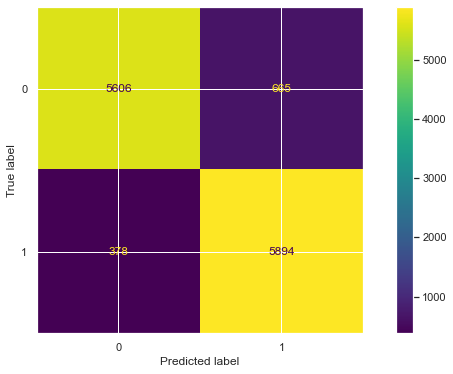

In [308]:
get_count_confusion_metrics(rf_clf,X_test,y_test)

<AxesSubplot:xlabel='Importance'>

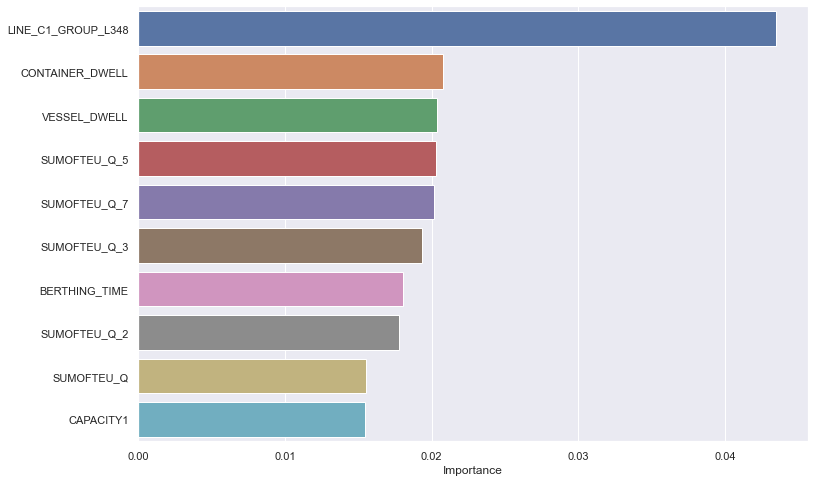

In [309]:
# Plot top 10 important features from random forest classifier
feature_imp = pd.DataFrame(rf_clf.feature_importances_, index=X_train.columns,columns=['Importance']).sort_values('Importance',ascending=False)
feature_imp = feature_imp.head(10)
feature_imp

plt.figure(figsize=(12,8))
sns.barplot(x=feature_imp['Importance'], y=feature_imp.index)

In [310]:
new_list = ['LINE_C1_GROUP_L348','CONTAINER_DWELL','VESSEL_DWELL','SUMOFTEU_Q_5','SUMOFTEU_Q_7',
           'SUMOFTEU_Q_3','BERTHING_TIME','SUMOFTEU_Q_2','SUMOFTEU_Q','CAPACITY1']

In [311]:
# Scaling 
sc = StandardScaler()
X_scaled = sc.fit_transform(X[new_list])
X_scaled = pd.DataFrame(X_scaled, columns = new_list)

In [312]:
X = X_scaled

# Train-split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state =42)

In [313]:
# Set up params
model_params = {
    # randomly sample numbers from 4 to 204 estimators
    'n_estimators': randint(4,200),
    # normally distributed max_features, with mean .25 stddev 0.1, bounded between 0 and 1
    'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
    # uniform distribution from 0.01 to 0.2 (0.01 + 0.199)
    'min_samples_split': uniform(0.01, 0.199)
}

In [314]:
%%time

# Create random forest classifier model
rf_model = RandomForestClassifier()

# Set up random search meta-estimator
# This will train 5 models over 5 folds of cross validation (25 models total)
clf = RandomizedSearchCV(rf_model, model_params, n_iter=5, cv=5, random_state=42)

# Train the random search meta-estimator on resampled train data to find the best model out of 5 candidates
rf_clf = clf.fit(X_train, y_train)

# Print winning set of hyperparameters
print(rf_clf.best_estimator_.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 0.26338715088042397, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 0.021558638821471694, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 91, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Wall time: 43.7 s


In [317]:
#-------------------------------- Model testing ---------------------------------#

# Predict for X_test data set using the fitted model
y_pred_rf_clf = rf_clf.predict(X_test)

In [316]:
#-------------------------------- Model evaluation ---------------------------------#
# Evaluate model accuracy using fitted y value and actual y_test
# Evaluation metrics to be used - eg. Precision, Recall, confusion matrix, ROC 

# Probabilities prediction on test set
probabilities = rf_clf.predict_proba(X_test)

In [318]:
# Display AUC and confusion matrix
print_metrics((y_test == 1), probabilities, 0.5)

                 Confusion matrix
                 Actual negative    Actual positive
Score negative      3951              2320
Score positive      2796              3476

Accuracy        0.59
AUC             0.64
Macro precision 0.59
Macro recall    0.59
 
           Negative     Positive
Num case     6271          6272
Precision    0.59          0.60
Recall       0.63          0.55
F1           0.61          0.58


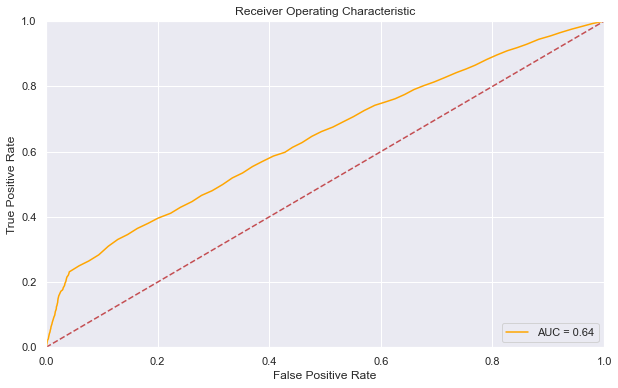

In [319]:
plot_auc((y_test == 1), probabilities)

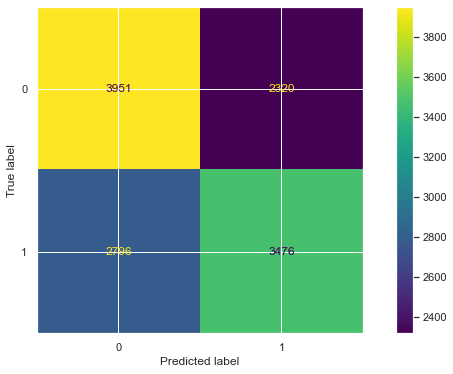

In [320]:
get_count_confusion_metrics(rf_clf,X_test,y_test)

In [322]:
import scikitplot as skplt

In [324]:
from mlxtend.evaluate import lift_score

1.1993522758482276

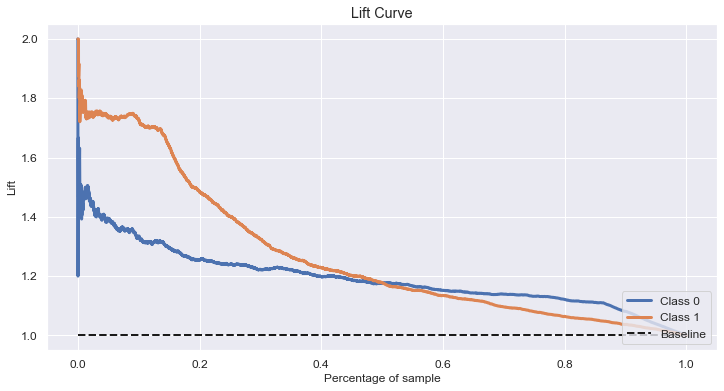

In [325]:
# Plot the lift chart from the best model

# Probabilities prediction on test set data
y_test_probs = rf_clf.predict_proba(X_test)

skplt.metrics.plot_lift_curve(y_test,y_test_probs,figsize=(12, 6))

lift_score(y_test,y_pred_rf_clf)